In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import cv2
import pdb
import time
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import sys

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt

In [3]:
import albumentations
import segmentation_models_pytorch as smp
import pydicom
import ttach

In [4]:
import glob2
from joblib import Parallel, delayed

Starting from where we left in the previous notebook, we have now proper `csv`s with train and validation sets, we need now to setup the model..

## Some helper functions we'll use to create the loader to feed the data to the model

Data Augmentation transformation first:

In [5]:
## use the ToTensorV2 from albumentations 0.5.0 as ToTensor will be deprecated
class ToTensorV2(albumentations.BasicTransform):
    """Convert image and mask to `torch.Tensor`."""

    def __init__(self, always_apply=True, p=1.0):
        super(ToTensorV2, self).__init__(always_apply=always_apply, p=p)

    @property
    def targets(self):
        return {"image": self.apply, "mask": self.apply_to_mask}

    def apply(self, img, **params):
        return torch.from_numpy(img.transpose(2, 0, 1))

    def apply_to_mask(self, mask, **params):
        return torch.from_numpy(mask)

    def get_transform_init_args_names(self):
        return []

    def get_params_dependent_on_targets(self, params):
        return {}

def get_transforms(mode='train',image_size=1024):
    if mode == 'train':
        return albumentations.Compose([
            albumentations.Resize(image_size, image_size, p=1.),
#             albumentations.OneOf([
#                 albumentations.RandomGamma(gamma_limit=(60, 120), p=0.9),
#                 albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                albumentations.CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=0.9),
#             ]),
#             albumentations.OneOf([
#                 albumentations.Blur(blur_limit=4, p=1),
#                 albumentations.MotionBlur(blur_limit=4, p=1),
#                 albumentations.MedianBlur(blur_limit=4, p=1)
#             ], p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
#             albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20,
#                                             interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=1),
            albumentations.augmentations.transforms.RandomCrop(512,512,p=1.),
            albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
            ToTensorV2()
        ])
    else:
        return albumentations.Compose([
            albumentations.Resize(image_size, image_size, p=1.),
            albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
            ToTensorV2()
        ])

### Dataset

Notice that now we return both the image and a tuple with mask and label for each sample from the dataset. This is because we'll expand our model with an extra classification head that'll drive the classification task.

In [6]:
def rle_to_float_mask(rle, height=1024, width=1024, fill_value=1.):
    mask = np.zeros((height * width,), np.float32)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        mask[start: end] = fill_value
        start = end
    mask = mask.reshape(width, height).T # .T is important!
    return mask

class Siim_Dataset(Dataset):

    def __init__(self,base_path,dataframe,transform = None):
        self.transform = transform
        self.names = list(dataframe.index)
        self.labels = dataframe['Labels']
        self.rle_masks = dataframe['RLEMasks']
        self.base_path = base_path

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):

        name = self.names[idx]
        image_path = self.base_path+name+'.png'
        image = cv2.imread(image_path)
        label = torch.FloatTensor([self.labels[idx]])

        rle = self.rle_masks[idx]

        mask = np.zeros((1024, 1024),dtype=np.float32)
        if '-1' not in rle:
            for e in rle:
                mask += rle_to_float_mask(e)
            mask[mask>1.] = 1.
  
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            # I'll assume that torch tensors come out of here
            image = augmented['image']#.permute(2, 0, 1)
            # the permutation is unnecessary because of ToTensor()
            mask = augmented['mask'].unsqueeze(0)

        return image, (mask, label)

I'll define now a custom [Sampler](https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html) that'll help us control the proportion of positive/negative examples at each subsequent epoch of training, to gradually decrease the proportion of negatives.

The idea is that because we only have 22% of positive examples we don't want the network to learn to predict empty masks just because it's the most probable case. Hopefully it'll speed up training.

In [7]:
class FixedProportionSampler(torch.utils.data.sampler.Sampler):
    '''
    Sampler that evolves the proportion of positive/negative samples over the specified number of epochs
    '''
    def __init__(self, dataset: Siim_Dataset, positive_ratio_range, epochs = 10):
        super().__init__(dataset)
        assert len(positive_ratio_range) == 2

        self.positive_indices = np.where(dataset.labels == 1)[0]
        self.negative_indices = np.where(dataset.labels == 0)[0]
        self.positive_ratio_range = positive_ratio_range
        self.n_positives = len(self.positive_indices)
        self.current_epoch = 0
        self.epochs = epochs

    @property
    def positive_ratio(self) -> float:
        np.random.seed(self.current_epoch)
        min_ratio, max_ratio = self.positive_ratio_range
        return max_ratio - (max_ratio - min_ratio) / (self.epochs-1) * self.current_epoch

    @property
    def n_negatives(self) -> int:
        assert self.positive_ratio <= 1.0
        return int(self.n_positives // self.positive_ratio - self.n_positives)

    def __iter__(self):
        negative_indices = np.random.choice(self.negative_indices, size=self.n_negatives)
        indices = np.random.permutation(np.hstack((negative_indices, self.positive_indices)))
        return iter(indices.tolist())

    def __len__(self) -> int:
        return self.n_positives + self.n_negatives

    def set_epoch(self, epoch):
        self.current_epoch = epoch

Now we can put all thaat together and create a method that will create the correct dataloader for us

In [8]:
def get_loader(
    base_path: str,
    csv_name: str,
    mode: str,
    batch_size: int,
    img_size: int = 1024,
    positive_ratio_range = (0.3, 0.8),
    epochs: int = 10,
    num_workers: int = 1
):
    _df = pd.read_csv(base_path+csv_name,index_col=0,converters={"RLEMasks": lambda x: x.strip("[]").replace("'","").split(", ")})
    _transforms = get_transforms(mode,img_size)

    dataset = Siim_Dataset(dataframe=_df,base_path=base_path,transform=_transforms)

    sampler = FixedProportionSampler(dataset = dataset, positive_ratio_range=positive_ratio_range, epochs=epochs)
    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=num_workers, pin_memory=False
    )
    return loader

### Everything in order, time to define our training

First, let's define our `ComboLoss` that will combine several losses for all our tasks.

In [9]:
class ComboLoss(nn.Module):
    def __init__(self,**kwargs):
        super(ComboLoss,self).__init__(**kwargs)
        self.dice_loss = smp.utils.losses.DiceLoss(activation='sigmoid')
            # note the activation, Dice loss in smp assumes activated input 
            # so we need to pass a sigmoid activation otherwise Dice will use
            # raw logits
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_cls_loss = nn.BCEWithLogitsLoss()
        self.__name__ = 'combo_loss'

    def forward(self,pred,y):
        tot_loss = 0.
        pred_mask, pred_label = pred
        y_mask, y_label = y

        tot_loss += 0.7 * self.dice_loss(pred_mask,y_mask)
        tot_loss += 0.25 * self.bce_loss(pred_mask,y_mask)
        tot_loss += 0.05 * self.bce_cls_loss(pred_label,y_label)

        return tot_loss

Next, define the training functions!
I'll use the implementation from the [`segmentation models pytorch`](https://github.com/qubvel/segmentation_models.pytorch) and adapt them to my needs. 

In particular amongst other changes we need to extend these classes to support:
* Our dataset and model output, that will return both masks and class labels
* a custom learning rate scheduler
* the possibility of freezing the batchnormalization layers, in case of low batch sizes

In [10]:
class Epoch:

    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = smp.utils.meter.AverageValueMeter()
        metrics_meters = {metric.__name__: smp.utils.meter.AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            for x, y in iterator:
                x = x.to(self.device)
                y = [y[0].to(self.device),y[1].to(self.device)] #put both to device
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred[0], y[0]).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs



class ScheduledTrainEpochFrozenBN(Epoch):

    def __init__(self, model, loss, metrics, optimizer, scheduler=None, device='cpu', verbose=True, frozen_bn=False):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='train',
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.frozen_bn = frozen_bn

    def on_epoch_start(self):
        self.model.train()
        # freeze batchnorm layers
        if self.frozen_bn:
            for module in self.model.modules():
                if isinstance(module, torch.nn.modules.BatchNorm1d):
                    module.eval()
                if isinstance(module, torch.nn.modules.BatchNorm2d):
                    module.eval()
                if isinstance(module, torch.nn.modules.BatchNorm3d):
                    module.eval()                        


    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()
        if self.scheduler is not None:
            self.scheduler.step()
        return loss, prediction


class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

## Architecture design

Relying heavily on `smp` again, UNet with various imagenet-trained backbones, with an extra classification head made up by an Adaptive Pooling layer, Dropout and Linear layer, with no activation (*i.e.* with logits as outputs)

An example architecture (image credit to the original [UNet paper](https://arxiv.org/abs/1505.04597) with some personal modifications) : 
![arch-design =600x600](./images/unet.png)

The actual dimensions of the layers will depend on the chosen backbone

In [12]:
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.2,               # dropout ratio, default is None
    activation=None,           # activation function, default is None
    classes=1,                 # define number of output labels
)

backbone = 'resnet34' # resnet34, se_resnext50_32x4d, efficientnet-b4 ...?
model = smp.Unet(backbone, classes=1, encoder_weights='imagenet', aux_params=aux_params) #
# model = nn.DataParallel(model)

Init everything and build the training loop

In [13]:
loss = ComboLoss()

metrics = [
    smp.utils.metrics.IoU(activation='sigmoid') 
    # see above to see why the activation is necessary
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=5e-5, weight_decay=0.00001),
])

epochs=50

train_loader = get_loader('siim/train_png/','train.csv','train',8,1024//4*3, (0.22,0.99),epochs,8)
valid_loader = get_loader('siim/train_png/','valid.csv','valid',8,1024//4*3, (0.22,0.99),epochs,8)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=7.5e-5, steps_per_epoch=1, epochs=epochs)

In [14]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
DEVICE = 'cuda'
train_epoch = ScheduledTrainEpochFrozenBN(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    # scheduler=scheduler, we'll step once per epoch
    device=DEVICE,
    verbose=True,
    frozen_bn=False
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Run training loop!

In [ ]:
import gc
max_score = 0
patience = 0

gc.collect()
for i in range(epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_loader.sampler.set_epoch(i)
    scheduler.step()
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), 'siim/best_'+backbone+'.pth')
        print('Model saved!')
    else: # add a patience parameter to check if we're stuck somewhere bad..
        patience += 1
        if patience > 10:
            patience = 0
            model.load_state_dict(torch.load('siim/best_'+backbone+'.pth'))
            print('Patience exhausted, restored previous checkpoint')
        
  # IoU: intersection over Union
  # DICE loss -- similar concept, see https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [16]:
torch.save(model.state_dict(), 'siim/last_'+backbone+'.pth')

## Inference

Let's now try to predict the mask on a test image (more for showing how to do it then for actually looking at the prediction!)

Start with defining with some Test Time Augmentations!

In [17]:
def get_base_transforms(image_size=1024):
    return albumentations.Compose([
        albumentations.Resize(image_size, image_size, p=1.),
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])

TTA = ttach.Compose( # somebasic TTA just to show how
    [
        ttach.HorizontalFlip(),
        ttach.VerticalFlip()    
    ]
)

Load saved model

In [22]:
# load best saved checkpoint
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.2,               # dropout ratio, default is None
    activation=None,           # activation function, default is None
    classes=1,                 # define number of output labels
)

best_model = smp.Unet(backbone, classes=1, aux_params=aux_params).cpu()
best_model.load_state_dict(torch.load('siim/best_'+backbone+'.pth'))
# best_model.load_state_dict(torch.load('siim/last_'+backbone+'.pth'))

<All keys matched successfully>

Test on images taken from the test dataset (here I also take one from the training to compare with the known masks)

tensor([0.1446])
tensor(0.8053)
Pneumothorax Predicted


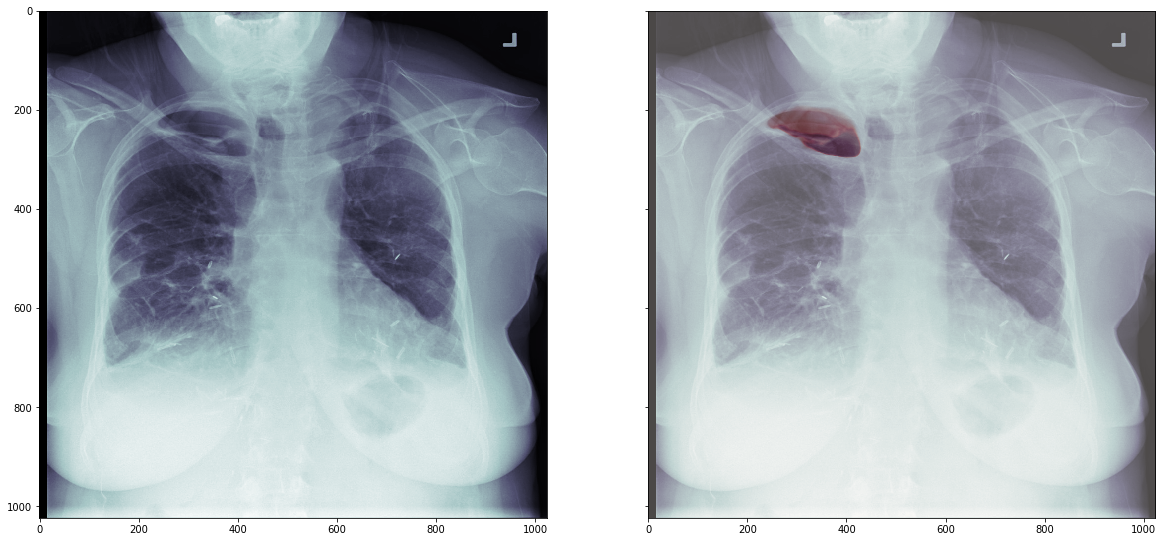

In [25]:
train_out_path = 'siim/test_png'
if not os.path.exists(train_out_path):
    os.makedirs(train_out_path)
    
base_trans = get_base_transforms(image_size = 1024)
    
# file_path = 'siim/dicom-images-test/_/_/ID_0011fe81e.dcm' 

file_path = 'siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5698.1517875189.651634/1.2.276.0.7230010.3.1.3.8323329.5698.1517875189.651633/1.2.276.0.7230010.3.1.4.8323329.5698.1517875189.651635.dcm'

dicom_file = pydicom.dcmread(file_path)

# make into a PNG
img = dicom_file.pixel_array
png_name = train_out_path + '/' + file_path.split('/')[-1][:-4] + '.png'
cv2.imwrite(png_name, img)
img = cv2.imread(png_name) #make sure you read in the 3 channel image

# apply base transforms (albumentation)
img = base_trans(image=img)

# make it into a batch
img = img['image'].unsqueeze(0)

# apply TTA
masks = []
logits = []
for t in TTA: # custom transforms or e.g. tta.aliases.d4_transform() 
    
    # augment image
    augmented_image = t.augment_image(img)
    
    # pass to model and get the prediction
    with torch.no_grad():
        best_model.eval()
        model_output = best_model(augmented_image)
    
    # reverse augmentation for mask and label
    deaug_mask = t.deaugment_mask(model_output[0])
    deaug_logits = t.deaugment_label(model_output[1])
    
    # save results
    masks.append(deaug_mask)
    logits.append(deaug_logits)
    
# reduce results as you want, in this case I use mean
masks = torch.cat(masks,dim=0)
mask = torch.sigmoid(masks.mean(dim=0).squeeze(0))

logits = torch.cat(logits,dim=0)
pred_pneut = torch.sigmoid(logits.mean(dim=0))

# we can either plot this or apply some 
# thresholding to make the mask crispier

prediction_criterion = pred_pneut < 0.4 or mask.sum() < 800

print(pred_pneut)
print(mask.sum())


if prediction_criterion :
    print('No Pneumothorax Predicted')
    plt.figure(figsize=(10,10))
    plt.imshow(dicom_file.pixel_array, cmap=plt.cm.bone)
else:
    print('Pneumothorax Predicted')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))
    ax1.imshow(dicom_file.pixel_array, cmap=plt.cm.bone)
    ax2.imshow(dicom_file.pixel_array, cmap=plt.cm.bone)
    ax2.imshow(mask, alpha=0.3, cmap="Reds")

plt.show()

We'll need to further binarize the pixels in the mask when we're ready to produce a binary image.